# Sentence Encoding with ELMo

#### Install

In [ ]:
!pip install mxnet --pre

In [ ]:
!pip install gluonnlp --pre

In [ ]:
!pip install sacremoses

#### Imports 

In [1]:
import bs4
import gluonnlp as nlp
from html import unescape
from IPython.display import YouTubeVideo
import mxnet as mx
import nltk
from nltk import sent_tokenize
import requests

## Select Source

In [2]:
YT_VIDEO_ID = 'h9rLfg8jzZY'

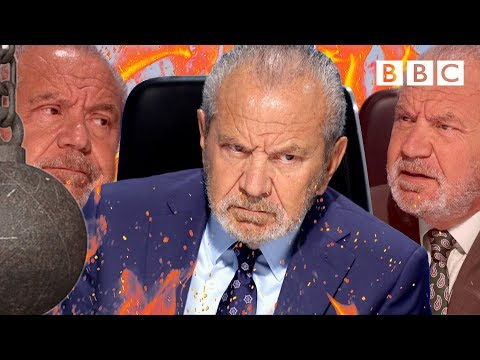

In [3]:
YouTubeVideo(YT_VIDEO_ID)

## Extract Transcript

In [4]:
response = requests.get('http://video.google.com/timedtext?lang=en&v={}'.format(YT_VIDEO_ID))

In [5]:
soup = bs4.BeautifulSoup(response.content, "lxml")
text_nodes = soup.findAll('text')
text_parts = [unescape(n.contents[0]) for n in text_nodes]
text = " ".join(text_parts).replace('\n', ' ')

In [6]:
# print(soup.prettify())
print(text)

Good morning. ALL: Good morning, Lord Sugar. This task was all about negotiation... 59 euros, please. Would you do it for 58.99? LORD SUGAR: ..logistics... Have you already got it? Cos we're right outside the shop. ON PHONE: We're ready. LORD SUGAR: ..and identification of the products. We're not looking for an actual octopus, are we? FLAT NOTE PLAYS LORD SUGAR: I think I'll start with the ladies first. There was a real impatience in the team in wanting to sit down and plan. An assault place on a market. Much closer to where we are. We're wasting time. - You lost control then, did you? - I didn't lose control, but I felt forced to split the team. It was impossible. This is a classic example of the blind leading the blind. I've got your CV here. 'Communication and pitching I will do well.' - Absolutely. - He sort of fell apart. - Um... - Forgetting my name. Um... I believe that we had an out-of-date product. That comic... The other team got orders. - Gentlemen, now, Frank... - Yes, Lord

# Tokenize

In [7]:
# nltk.download('punkt')

In [8]:
sentences = nltk.sent_tokenize(text)
# work with a single sentence to begin with...
sentence = sentences[8]
print(sentence)

We're not looking for an actual octopus, are we?


In [9]:
tokenizer = nlp.data.SacreMosesTokenizer()
tokens = ['<bos>'] + tokenizer(sentence) + ['<eos>']
print(tokens)

['<bos>', 'We', '&apos;re', 'not', 'looking', 'for', 'an', 'actual', 'octopus', ',', 'are', 'we', '?', '<eos>']


In [10]:
vocab = nlp.vocab.ELMoCharVocab()
tokens_char_idx = mx.nd.array([vocab[t] for t in tokens])
# only showing first ten characters of each word
print(tokens_char_idx[:, :10])


[[258. 256. 259. 260. 260. 260. 260. 260. 260. 260.]
 [258.  87. 101. 259. 260. 260. 260. 260. 260. 260.]
 [258.  38.  97. 112. 111. 115.  59. 114. 101. 259.]
 [258. 110. 111. 116. 259. 260. 260. 260. 260. 260.]
 [258. 108. 111. 111. 107. 105. 110. 103. 259. 260.]
 [258. 102. 111. 114. 259. 260. 260. 260. 260. 260.]
 [258.  97. 110. 259. 260. 260. 260. 260. 260. 260.]
 [258.  97.  99. 116. 117.  97. 108. 259. 260. 260.]
 [258. 111.  99. 116. 111. 112. 117. 115. 259. 260.]
 [258.  44. 259. 260. 260. 260. 260. 260. 260. 260.]
 [258.  97. 114. 101. 259. 260. 260. 260. 260. 260.]
 [258. 119. 101. 259. 260. 260. 260. 260. 260. 260.]
 [258.  63. 259. 260. 260. 260. 260. 260. 260. 260.]
 [258. 257. 259. 260. 260. 260. 260. 260. 260. 260.]]
<NDArray 14x10 @cpu(0)>


## Load ELMo Model

In [11]:
elmo_bilm, _ = nlp.model.get_model('elmo_2x1024_128_2048cnn_1xhighway', dataset_name='gbw',
                                   pretrained=True, ctx=mx.cpu())
print(elmo_bilm)

ELMoBiLM(
  (_elmo_char_encoder): ELMoCharacterEncoder(
    (_char_embedding): Embedding(262 -> 16, float32)
    (_convolutions): ConvolutionalEncoder(
      (_convs): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv1D(16 -> 32, kernel_size=(1,), stride=(1,))
          (1): HybridLambda(<lambda>)
          (2): Activation(relu)
        )
        (1): HybridSequential(
          (0): Conv1D(16 -> 32, kernel_size=(2,), stride=(1,))
          (1): HybridLambda(<lambda>)
          (2): Activation(relu)
        )
        (2): HybridSequential(
          (0): Conv1D(16 -> 64, kernel_size=(3,), stride=(1,))
          (1): HybridLambda(<lambda>)
          (2): Activation(relu)
        )
        (3): HybridSequential(
          (0): Conv1D(16 -> 128, kernel_size=(4,), stride=(1,))
          (1): HybridLambda(<lambda>)
          (2): Activation(relu)
        )
        (4): HybridSequential(
          (0): Conv1D(16 -> 256, kernel_size=(5,), stride=(1,))
          (1): HybridL

## Use ELMo Model

In [12]:
# create 'mini-batch' for single sample
hidden_state = elmo_bilm.begin_state(mx.nd.zeros, batch_size=1)
data = tokens_char_idx.expand_dims(0)
mask = mx.nd.ones(shape=(1, data.shape[1]))

In [13]:
# run through network
all_token_encodings, hidden_state = elmo_bilm(data, hidden_state, mask)

In [14]:
print([layer.shape for layer in all_token_encodings])

[(1, 14, 256), (1, 14, 256), (1, 14, 256)]


In [15]:
token_encodings = all_token_encodings[-1][0]
print(token_encodings.shape)

(14, 256)


In [16]:
print(tokens)

['<bos>', 'We', '&apos;re', 'not', 'looking', 'for', 'an', 'actual', 'octopus', ',', 'are', 'we', '?', '<eos>']


In [17]:
trimmed_encodings = token_encodings[1:-1]
print(trimmed_encodings.shape)

(12, 256)


In [18]:
avg_encoding = trimmed_encodings.mean(axis=0)
print(avg_encoding.shape)

(256,)


In [19]:
avg_encoding.asnumpy()

array([ 2.52639025e-01, -1.87900975e-01, -7.07949340e-01, -4.24527973e-01,
       -2.87790626e-01,  8.50579217e-02,  1.73480973e-01,  7.74093628e-01,
        5.86796291e-02,  5.60261965e-01, -6.87165499e-01, -5.73534846e-01,
        5.44850945e-01, -4.55764383e-01,  8.57290998e-02, -1.01671018e-01,
        1.03320944e+00, -7.12750375e-01,  4.71048504e-01,  4.68130223e-02,
       -9.62599292e-02,  3.12559992e-01, -2.13648498e-01,  3.29402715e-01,
       -2.57592320e-01, -5.16486764e-02,  8.16842020e-01, -2.13486865e-01,
       -5.46765983e-01,  6.35102630e-01, -2.09702373e-01, -2.41498947e-02,
        5.64629436e-01, -3.67517620e-01,  5.36779761e-01,  9.55529809e-02,
        3.92763495e-01, -4.87310201e-01, -6.24044538e-02,  6.52903557e-01,
        2.33841598e-01,  1.12661652e-01, -1.34597510e-01, -2.44522110e-01,
       -8.98824394e-01, -2.15212643e-01,  4.94378537e-01, -5.50776720e-01,
       -5.67081809e-01, -5.24373412e-01,  7.17356205e-01, -2.02242598e-01,
        8.64697933e-01, -

## Create a Sentence Encoder

In [20]:
class SentenceEncoder():
    def __init__(self):
        """
        Sentence encoder that works on single sentence strings.
        """
        self._tokenizer = nlp.data.SacreMosesTokenizer()
        self._vocab = nlp.vocab.ELMoCharVocab()
        self._model, _ = nlp.model.get_model('elmo_2x1024_128_2048cnn_1xhighway',
                                             dataset_name='gbw', pretrained=True, ctx=mx.cpu())
    
    def encode(self, sentence, output_layer_idx=-1):
        tokens = ['<bos>'] + tokenizer(sentence) + ['<eos>']
        tokens_char_idx = mx.nd.array([self._vocab[t] for t in tokens])
        hidden_state = self._model.begin_state(mx.nd.zeros, batch_size=1)
        data = tokens_char_idx.expand_dims(0)
        mask = mx.nd.ones(shape=(1, data.shape[1]))
        token_encodings, hidden_state = self._model(data, hidden_state, mask)
        # take encodings from last layer, and take single sample.
        token_encodings = token_encodings[-1][0]
        sentence_encoding = self._aggregate_token_encodings(token_encodings)
        return sentence_encoding
    
    def _aggregate_token_encodings(self, token_encodings):
        trimmed = token_encodings[1:-1]
        avg = trimmed.mean(axis=0)
        return avg.asnumpy()

In [21]:
sent_encoder = SentenceEncoder()

In [22]:
sent_encoding = sent_encoder.encode("We're not looking for an actual octopus, are we?")
print(sent_encoding)

[ 2.52639025e-01 -1.87900975e-01 -7.07949340e-01 -4.24527973e-01
 -2.87790626e-01  8.50579217e-02  1.73480973e-01  7.74093628e-01
  5.86796291e-02  5.60261965e-01 -6.87165499e-01 -5.73534846e-01
  5.44850945e-01 -4.55764383e-01  8.57290998e-02 -1.01671018e-01
  1.03320944e+00 -7.12750375e-01  4.71048504e-01  4.68130223e-02
 -9.62599292e-02  3.12559992e-01 -2.13648498e-01  3.29402715e-01
 -2.57592320e-01 -5.16486764e-02  8.16842020e-01 -2.13486865e-01
 -5.46765983e-01  6.35102630e-01 -2.09702373e-01 -2.41498947e-02
  5.64629436e-01 -3.67517620e-01  5.36779761e-01  9.55529809e-02
  3.92763495e-01 -4.87310201e-01 -6.24044538e-02  6.52903557e-01
  2.33841598e-01  1.12661652e-01 -1.34597510e-01 -2.44522110e-01
 -8.98824394e-01 -2.15212643e-01  4.94378537e-01 -5.50776720e-01
 -5.67081809e-01 -5.24373412e-01  7.17356205e-01 -2.02242598e-01
  8.64697933e-01 -5.81068397e-01 -7.44998693e-01  1.16448700e-01
  2.21855149e-01 -5.68845272e-01 -9.71427441e-01  4.15678620e-01
  7.06089586e-02  1.30083